In [124]:
import glob

## Data preprocessing

In [125]:
# go through all logs and accuracies
logs = glob.glob("new_logs*.txt")
accuracies = glob.glob("new_accuracy*.txt")

In [126]:
def convert_tstr_to_s(t_str):
    minutes = float(t_str.split('m')[0])
    seconds = float(t_str.split('m')[1].rstrip('s'))
    
    return minutes * 60 + seconds

def extract_results(acc_file, log_file):
    # 1. iterate through all accuracies of experiments

    experiments = []
    exp = ''
    res_acc = {}
    acc = open(acc_file, 'r')
    for l in acc:
        if "Experiment" in l:
            # extract experiment information
            exp = l.rstrip("\n")
            experiments += [exp]
            res_acc[exp] = {}
        elif len(l.rstrip("\n").split(' ')) > 1:
            # store accuracy result from Spark
            res_acc[exp]['spark'] = float(l.rstrip("\n").split(' ')[-1])
        else:
            # store accuracy result from Rumble
            res_acc[exp]['rumble'] = float(l.rstrip("\n").split(' ')[0])
    acc.close()

    # 2. iterate through all time logs
    res_t = {}
    c = 0
    i = 0
    log = open(log_file, 'r')
    for l in log:
        if "real" in l:
            exp = experiments[i]
            if len(l.rstrip('\n').split('\t')) == 2:
                if c == 0:
                    res_t[exp] = {}
                    res_t[exp]['rumble'] = l.rstrip('\n').split('\t')[1]
                    c += 1
                elif c == 1:
                    res_t[exp]['spark'] = l.rstrip('\n').split('\t')[1]
                    c = 0
                    i += 1
    log.close()
    return res_acc, res_t

def add_time_results(df_criteo, df_yfcc, res_t):
    # creates dataframe for sns plots
    for exp in res_t.keys():
            for j in ['rumble','spark']:
                t = res_t[exp][j]
                m = exp.split(' ')[2]
                if 'logistic' in m:
                    m = m.capitalize()
                p = int(exp.split(' ')[1]) + 1
                # go through all experiments
                if 'Criteo' in exp:
                    df_criteo = df_criteo.append({'time (s)': convert_tstr_to_s(t), 'Model pipeline': f'{m}\npipeline {p}', 'Framework': j.capitalize()}, ignore_index=True)
                elif 'YFCC' in exp:
                    df_yfcc = df_yfcc.append({'time (s)': convert_tstr_to_s(t), 'Model pipeline': f'{m}\npipeline {p}', 'Framework': j.capitalize()}, ignore_index=True)
                    
    return df_criteo, df_yfcc

## Plot generation

In [134]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(8,5)})

df_criteo = pd.DataFrame(columns = ['time (s)','Model pipeline','Framework'])
df_yfcc = pd.DataFrame(columns = ['time (s)','Model pipeline','Framework'])

for acc_file, log_file in zip(accuracies, logs):
    res_acc, res_t = extract_results(acc_file, log_file)
    df_criteo, df_yfcc = add_time_results(df_criteo, df_yfcc, res_t)

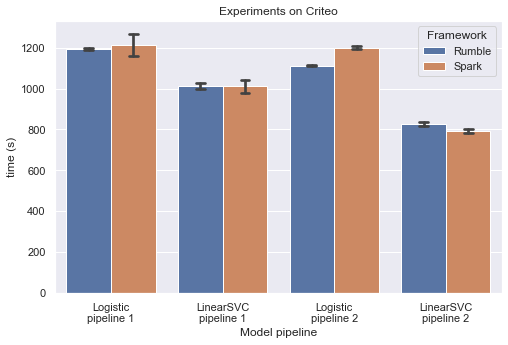

In [151]:
import matplotlib.pyplot as plt
ax = sns.barplot(x="Model pipeline", y="time (s)", hue="Framework", data=df_criteo, ci="sd", capsize=.08).set_title("Experiments on Criteo")
plt.savefig('criteo_time.pdf')

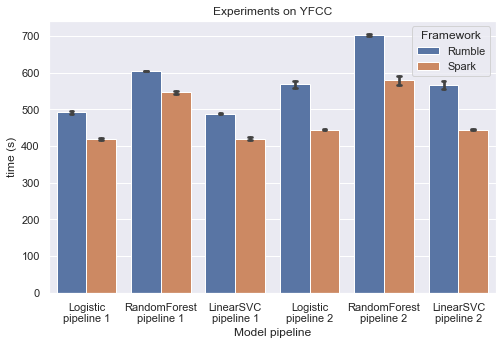

In [150]:
ax = sns.barplot(x="Model pipeline", y="time (s)", hue="Framework", data=df_yfcc, ci="sd", capsize=.05).set_title("Experiments on YFCC")
plt.savefig('yfcc_time.pdf')